In [11]:
from __future__ import print_function, division
import os
import sys
# os.environ['CUDA_VISIBLE_DEVICES'] = "0,1,2,3"

In [12]:
#%%
import torch as T
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import save_image
from torch.utils.data import DataLoader, Dataset
import scipy.linalg
from functools import partial
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
import scipy.sparse as sparse
from scipy import stats
import gc
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import seaborn as sb
from pandas import DataFrame
from scipy.spatial import distance
from scipy.cluster import hierarchy
from torchvision.transforms import Resize
import dill
from joblib import Parallel, delayed
import cv2
import resource
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo
import apex # https://github.com/NVIDIA/apex.git
from apex.amp import amp
import gc


import os, sys, datetime
import itertools
LF_CODE_PATH = os.path.expanduser('~/projects/LFAnalyze/code')
FT_CODE_PATH = os.path.expanduser('~/projects/fishTrax/code/analysis/')
FD_CODE_PATH = os.path.expanduser('~/projects/fish_despair_notebooks/src/')
sys.path.insert(0,LF_CODE_PATH)
sys.path.insert(0,FT_CODE_PATH)
sys.path.insert(0,FD_CODE_PATH)

import passivity_2p_imaging_utils as p2putils
reload(p2putils)
tmp_dir = '/tmp/'
all_data = p2putils.get_all_datasets(tmp_dir=tmp_dir)

sys.path.insert(0,".")
from deepfish.helpers import get_frames_from_z, get_imaging_from_fish, gen_imaging, resize_volume, resize_batch, read_cnmf, no_overlap_idx, train_valid_test_split, train_test_split, pad_imaging

from deepfish.stats import sampleMSE
from deepfish.plot import interpret, plot_model_vs_real, makePredVideo, MSEbyDist, plot_embedding_over_time

from deepfish.data import ZebraFishData
# from deepfish.deep_kSVD import Deep_KSVD, train
from deepfish.half_precision import network_to_half
from deepfish.volume import volume_mse

In [3]:
gen = False
# gen = True
cuda=True
# cnmf=True
cnmf=False
half=True
half=False
multi_gpu = True
num_workers = 16
prev_frames = 5
next_frames = 5
fidx = 0
model = "freeze"

In [4]:
if fidx==0:
#     model_name = "180825_f01555_deep_skip_X=t-4:t_Y=t+1,t+5_epochs=15_Y_MSE=2.523E+01_Y_val_MSE=3.078E+01"
#     model_name = "180919-04:35AM_f01555_freeze_X=t-4:t_Y=t+1,t+5_epochs=15_Y_MSE=4.242E+01_Y_val_MSE=4.982E+01"
    model_name = "180919-05:40AM_f01555_freeze_X=t-4:t_Y=t+1,t+5_epochs=15_Y_MSE=4.307E+01_Y_val_MSE=5.226E+01"
elif fidx==1:
    model_name = "180906-09:22PM_f01575_skip_X=t-4:t_Y=t+1,t+5_epochs=15_Y_MSE=2.482E+01_Y_val_MSE=2.938E+01"
    
fishIdx = [("e", 2),  ("e", 5), ("c", 1),  ("c", 6),  ("enp", 1), ("enp", 5)]

if model=="skip":
    from deepfish.deep_skip import DeepSkip, train
    Model = DeepSkip
elif model=='kSVD':
    from deepfish.deep_kSVD import Deep_KSVD, train
    Model = Deep_KSVD
elif model=='freeze':
    from deepfish.deep_freeze import DeepFreeze, train
    Model = DeepFreeze
    
f = all_data[fishIdx[fidx][0]][fishIdx[fidx][1]]


frame_times = T.from_numpy(f.frame_st.mean(1).astype(np.float32))
shocks = T.FloatTensor(frame_times.shape).zero_()
shocks[np.searchsorted(f.frame_et[:,-1], f.shock_st,side="left")] = 1

tail_movements = T.FloatTensor(frame_times.shape).zero_()
tail_movements[np.searchsorted(f.frame_et[:,-1],
    f.tail_movement_start_times,side="left")] = 1

fishpath = '/data2/Data/MPzfish/drn_hb/{}/{}_small.npz'.format(f.fishid, f.fishid)
imaging = np.load(fishpath)['fish']
imaging = pad_imaging(imaging, 128, 256)

In [5]:
tvt_split = train_test_split(2826, nchunks=20)
total_examples = sum([len(x) for x in tvt_split.values()])
print(["{}: {} ({:.2f}%)".format(k, len(v), 100*len(v)/total_examples) for k,v in tvt_split.items()])

train_data = ZebraFishData(imaging,shocks,tail_movements,
                        tvt_split['train'], prev_frames,next_frames)

# valid_data = ZebraFishData(imaging,shocks,tail_movements,
#                         tvt_split['validation'], prev_frames,next_frames)

test_data = ZebraFishData(imaging,shocks,tail_movements,
                        tvt_split['test'], prev_frames,next_frames)

total_data = ZebraFishData(imaging,shocks,tail_movements,
                        None, prev_frames,next_frames)

_, nZ, H, W = train_data[0][0]["brain"].shape

nEmbedding = 20
batch_size = 8
batch_size = 32

conv_model = Model(nZ,H,W,nEmbedding,prev_frames,next_frames,
                   tensor=T.cuda.FloatTensor)
if multi_gpu:
    conv_model = nn.DataParallel(conv_model)

conv_model.load_state_dict(T.load("/data2/trained_models/"+model_name+".pt"))

conv_model.cuda()
None

['test: 200 (8.14%)', 'train: 2257 (91.86%)', 'validation: 0 (0.00%)']


In [6]:
print(f.fishid)

f01555


In [7]:
df = f.get_roi_table()

In [8]:
M = f.get_signals_raw(z=None)
M = M.T

In [9]:
M.shape

(2826, 15888)

In [13]:
np.savetxt("/data2/Data/MPzfish/"+f.fishid+".csv", M, delimiter=",")

In [33]:
Mdf = DataFrame(M.T)

In [23]:
from rpy2.robjects import r, pandas2ri
from rpy2 import robjects

In [ ]:
filename = "/data2/Data/MPzfish/"+f.fishid+"_sig.r"
r_data = pandas2ri.py2ri(Mdf)
robjects.r.assign("my_df", r_data)
robjects.r("save(my_df, file='{}')".format(filename))

/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/rpy2/robjects/pandas2ri.py:57: UserWarning: Error while trying to convert the column "0". Fall back to string conversion. The error is: Conversion 'py2ri' not defined for objects of type '<class 'pandas.core.series.Series'>'
  (name, str(e)))
/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/rpy2/robjects/pandas2ri.py:57: UserWarning: Error while trying to convert the column "1". Fall back to string conversion. The error is: Conversion 'py2ri' not defined for objects of type '<class 'pandas.core.series.Series'>'
  (name, str(e)))
/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/rpy2/robjects/pandas2ri.py:57: UserWarning: Error while trying to convert the column "2". Fall back to string conversion. The error is: Conversion 'py2ri' not defined for objects of type '<class 'pandas.core.series.Series'>'
  (name, str(e)))
/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages

In [11]:
len(df)

15888

In [18]:
df.columns

Index([u'fishid', u'z', u'zndx', u'roi_img_label', u'coords', u'centroid_x',
       u'centroid_y', u'area', u'solidity', u'eccentricity', u'in_r_LHb',
       u'in_l_wholebrain', u'in_r_dthal', u'in_l_gc', u'in_l_vent',
       u'in_r_vent', u'in_l_vthal', u'in_r_tel', u'in_l_raphe', u'in_r_gc',
       u'in_r_raphe', u'in_l_ctel', u'in_l_tel', u'in_r_ctel', u'in_l_LHb',
       u'in_l_MHb', u'in_r_vthal', u'in_r_MHb', u'in_l_dthal', u'region',
       u'hemisphere', u'region_bilat'],
      dtype='object')

In [10]:
df.head()

,fishid,z,zndx,roi_img_label,coords,centroid_x,centroid_y,area,solidity,eccentricity,...,in_l_tel,in_r_ctel,in_l_LHb,in_l_MHb,in_r_vthal,in_r_MHb,in_l_dthal,region,hemisphere,region_bilat
0,f01555,0,0,1,"[[1, 27], [1, 28], [2, 26], [2, 27], [2, 28], ...",2.200000,27.200000,10,0.909091,0.828852,...,False,False,False,False,False,False,False,other,w,other
1,f01555,0,1,2,"[[1, 56], [1, 57], [1, 58], [1, 59], [1, 60], ...",1.923077,57.692308,13,1.000000,0.774346,...,False,False,False,False,False,False,False,other,w,other
2,f01555,0,2,3,"[[1, 61], [1, 62], [1, 64], [1, 65], [2, 62], ...",2.076923,63.461538,13,0.764706,0.872165,...,False,False,False,False,False,False,False,other,w,other
3,f01555,0,3,4,"[[1, 83], [1, 84], [1, 85], [1, 86], [2, 82], ...",2.076923,84.384615,13,0.928571,0.656671,...,False,False,False,False,False,False,False,other,w,other
4,f01555,0,4,5,"[[1, 87], [1, 88], [1, 89], [1, 90], [1, 91], ...",3.517857,90.446429,56,0.767123,0.888139,...,False,False,False,False,False,False,False,l_wholebrain,l,wholebrain


In [ ]:
def backprop_gradient_mask(model, batch, grad):
    """For one batch, backprop gradient mask."""    
    gc.collect()
    T.cuda.empty_cache()
    (X,Y) = batch
    model.zero_grad()
    model = conv_model.module
    xb = X['brain'].cuda()
    xb.requires_grad=True
#     (prev_vol, _), (pred_vol, _), _, _ = model(xb, Y['shock'].cuda())
    (prev_vol, _), (pred_vol, _), _, _ = model(xb,
                                               y_shock=Y['shock'].cuda(),
                                               x_shock=X['shock'].cuda())
    T.autograd.backward(pred_vol,grad)
    xb_grad = xb.grad.detach()
    return xb_grad

In [ ]:
imaging[0,0].shape

In [21]:
df.columns

Index([u'fishid', u'z', u'zndx', u'roi_img_label', u'coords', u'centroid_x',
       u'centroid_y', u'area', u'solidity', u'eccentricity', u'in_r_LHb',
       u'in_l_wholebrain', u'in_r_dthal', u'in_l_gc', u'in_l_vent',
       u'in_r_vent', u'in_l_vthal', u'in_r_tel', u'in_l_raphe', u'in_r_gc',
       u'in_r_raphe', u'in_l_ctel', u'in_l_tel', u'in_r_ctel', u'in_l_LHb',
       u'in_l_MHb', u'in_r_vthal', u'in_r_MHb', u'in_l_dthal', u'region',
       u'hemisphere', u'region_bilat'],
      dtype='object')

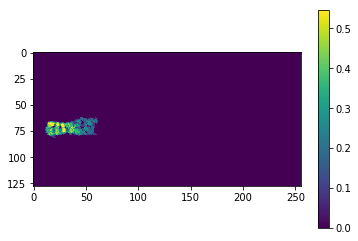

In [11]:
#given a fish object f...
#specify a condition to define a set of rois you want in the mask (could be based on activity)

region_mask = df['in_l_raphe']|df['in_r_raphe']
# region_mask = df['in_l_LHb']|df['in_r_LHb']

#extract the roi coords

df = f.get_roi_table()

#create a boolean mask
vol_size = imaging[0].shape
mask = np.zeros([vol_size[0], vol_size[1], vol_size[2]], dtype=np.float32)

small_idx = lambda X: list(map(lambda x: int(np.floor(x/2)), X))

for z in range(nZ):
    coords = df[(df.z==z)&(region_mask)].coords
    for c in coords:
        mask[z, small_idx(c[:,0]),small_idx(c[:,1])] = 1

plt.imshow(mask.mean(0))
plt.colorbar()
mask = T.from_numpy(mask.astype(np.float32))

In [12]:
def avg_vol_imshow(vol):
    mymax = max(np.abs(np.percentile(vol,.99)),np.abs(np.percentile(vol,.01)))
    plt.imshow(vol.mean(0),vmin=-mymax,vmax=mymax)
    plt.colorbar()

In [13]:
# find frame with max delta activation of region
val = 0
bz = 100
idx = None
realistic_mask = T.zeros_like(mask)
dataloader = DataLoader(train_data, batch_size=bz, shuffle=False)
for i,batch in enumerate(dataloader):
    (X, Y) = batch
    masked_sum = ((Y['brain'][:,4]-X['brain'][:,0]) * mask).sum(1).sum(1).sum(1)
    for j,ms in enumerate(masked_sum):
        if float(ms)>val:
            val = float(ms)
            idx = i*bz+j
            realistic_mask = Y['brain'][j,4]*mask
realistic_mask = realistic_mask/realistic_mask.max()

Text(0.5,1,'Frame 299')

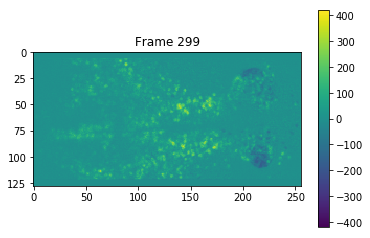

In [14]:
i = idx
next_vol = train_data[i][1]['brain'][-1]
avg_vol_imshow(next_vol)
plt.title("Frame " + str(idx))

In [15]:
(mask!=0).sum()

tensor(1870)

In [16]:
# find frame that has the most non-autocorr grads for mask

val = 0
bz = 6
non_autocorr_idx = None
dataloader = DataLoader(train_data, batch_size=bz, shuffle=False)
for i,batch in enumerate(tqdm(dataloader)):
    (X, Y) = batch
    bg = backprop_gradient_mask(conv_model.module, batch, mask)
    non_region_mask = (mask==0).type(T.FloatTensor)
    non_autocorr_sum = ((Y['brain'][:,4]-X['brain'][:,0]).abs() * non_region_mask).sum(1).sum(1).sum(1)
    for j,s in enumerate(non_autocorr_sum):
        if float(s)>val:
            val = float(s)
            non_autocorr_idx = i*bz+j
print(non_autocorr_idx)

KeyboardInterrupt: 

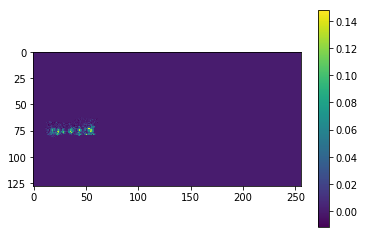

In [17]:
plt.imshow(realistic_mask.mean(0))
plt.colorbar()

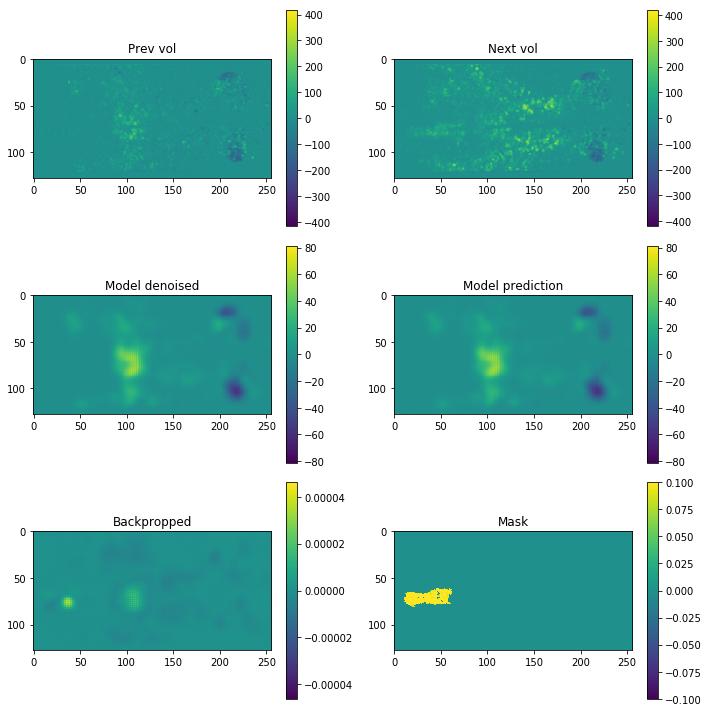

In [26]:
i = non_autocorr_idx
# mask = realistic_mask
prev_vol = train_data[i][0]['brain'][0]
next_vol = train_data[i][1]['brain'][-1]
plt.figure(figsize=(10,10))
plt.subplot(3,2,1)
avg_vol_imshow(prev_vol)
# plt.imshow(prev_vol.max(0)[0].numpy())
plt.title("Prev vol")
plt.subplot(3,2,2)
# plt.imshow(next_vol.max(0)[0].numpy())
avg_vol_imshow(next_vol)
plt.title("Next vol")

line_mask = T.zeros_like(next_vol)
line_mask[:,100:120,80:90] = next_vol[:,100:120,80:90] > 300

# ugly hack for collation
dataloader = DataLoader(train_data, batch_size=1, shuffle=False)
for j,x in enumerate(dataloader):
    if j==i:
        batch = x
        break

plt.subplot(3,2,3)
(X,Y) = batch
xb = X['brain'].cuda()
with T.no_grad():
#     (prev, _), (pred, _), _, _ = conv_model(xb, X['shock'].cuda())
    (prev, _), (pred, _), _, _ = conv_model(xb, X['shock'].cuda(), Y['shock'].cuda())
# plt.imshow(prev[0].mean(0).cpu().numpy())
avg_vol_imshow(prev[0])
plt.title("Model denoised")
plt.subplot(3,2,4)
# plt.imshow(pred[0].mean(0).cpu().numpy())
avg_vol_imshow(pred[-1])
plt.title("Model prediction")
        
plt.subplot(3,2,5)
bg = backprop_gradient_mask(conv_model.module, batch, mask)
# plt.imshow(bg[0].mean(0).mean(0))
# 1 in batch, avg all 5 frames
avg_vol_imshow(bg[0].mean(0))
plt.title("Backpropped")

plt.subplot(3,2,6)
# plt.imshow(mask.mean(0))
avg_vol_imshow(mask)
plt.title("Mask")

plt.tight_layout()

In [38]:
san = list(conv_model.module.parameters())[0]

In [42]:
np.all(san == san+1)

False

In [34]:
for i, param in enumerate(conv_model.module.parameters()):
    print(param.requires_grad)

0 False
1 False
2 False
3 False
4 False
5 False
6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 False
14 False
15 False
16 False
17 False
18 False
19 False
20 False
21 False
22 False
23 False
24 False
25 False
26 False
27 False
28 False
29 False
30 False
31 False
32 False
33 False
34 False
35 False
36 False
37 False
38 False
39 False
40 False
41 False
42 False
43 False
44 False
45 False
46 False
47 False
48 False
49 False
50 False
51 False
52 False
53 False
54 False
55 False
56 False
57 False
58 False
59 False
60 False
61 False
62 False
63 False
64 True
65 True
66 True
67 True
68 False
69 False
70 False
71 False
72 False
73 False
74 False
75 False
76 False
77 False
78 False
79 False
80 False
81 False
82 False
83 False
84 False
85 False
86 False
87 False
88 False
89 False
90 False
91 False
92 False
93 False
94 False
95 False
96 False
97 False
98 False
99 False
100 False
101 False
102 False
103 False
104 False
105 False
106 False
107 False
108 False
109 False
110 False
111 

In [33]:
for param in conv_model.module.predictor.parameters():
    param.requires_grad = True

Text(0.5,1,'Average backpropped gradient')

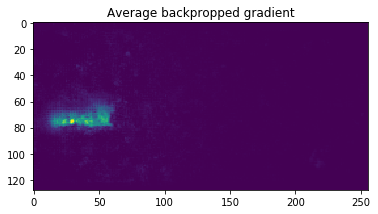

In [18]:
def avg_backprop_gradient_mask(model, data, grad,batch_size=16, progress=False):
    """For all batch, backprop gradient mask."""    
    dl = DataLoader(data, batch_size=batch_size, shuffle=False)
    if progress:
        dl = tqdm(dl)
    else:
        dl = dl
    res = []
    for batch in dl:
        res.append(backprop_gradient_mask(model, batch, grad))
    return T.cat(res).mean(0)

bg = avg_backprop_gradient_mask(conv_model.module, test_data, mask, progress=True)
plt.imshow(bg.max(0)[0].max(0)[0])  # max over prev frames, max over Z
plt.title("Average backpropped gradient")

In [19]:
train_bg = avg_backprop_gradient_mask(conv_model.module, train_data, hab_mask, progress=True)
plt.imshow(train_bg[0,6])

NameError: name 'hab_mask' is not defined

In [ ]:
def model_force_embedding(model, func, data, no_shock=False, batch_size=16, progress=False):
    """For all data, for each dim, map embedding and return vol x nDim.
    
    func :: (i, embedding) -> embedding"""
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=False)
    vols_by_dim = []
    halfembed = int(model.nEmbedding/2)
    
    with T.no_grad():
        for i in range(halfembed):
            res = []
            if progress:
                dl = tqdm(dataloader)
            else:
                dl = dataloader
            for (X,Y) in dl:
                encoded, logvar, skip = model.encode(X['brain'].cuda())
                # call func on latent being explored
                # map over batch
                latent_state_pred = T.cuda.FloatTensor(encoded.shape[0],halfembed).zero_()
                for b in range(encoded.shape[0]):
                    latent_state_pred[b] = func(i, encoded[b])
                if not no_shock:
                    x_shock = X['shock'].cuda()
                else:
                    x_shock = T.zeros(encoded.shape[0],prev_frames).cuda()
                pred_state = model.predict(latent_state_pred,x_shock)
                actual_pred_state = model.predict(encoded[:,:halfembed],x_shock)
                actual_pred_vol = model.decode(actual_pred_state,skip)[0] # ignore tail
                pred_vol = model.decode(pred_state,skip)[0] # ignore tail
                res.append((pred_vol-actual_pred_vol).cpu())
            if len(res)==1:
                vols_by_dim.append(res[0])
            else:
                vols_by_dim.append(T.cat(res))
            gc.collect()
            T.cuda.empty_cache()
    return T.stack(vols_by_dim)
    
def avg_vol_interpret(model, data, prev_frames):
    "Plot average prev & next frame for each latent dimension"
    plt.figure(figsize=(10,40))
    halfembed = int(model.nEmbedding/2)
    with T.no_grad():

        func = lambda i, embedding: T.from_numpy(np.eye(halfembed)[i].astype(np.float32)).cuda()[None]
        pred_vols = model_force_embedding(model, func, data, no_shock=True, progress=True)
        vmax = np.percentile(pred_vols.abs().numpy(), 99)
#         vmin = np.percentile(pred_vols.numpy(), 1)
        for i in range(halfembed):
            plt.subplot(1+nEmbedding,3,i*3+5)
            plt.imshow(pred_vols[i].mean(0)[6],vmin=-vmax, vmax=vmax)
            plt.title("Pred (Dim {})".format(i))

    plt.tight_layout()

avg_vol_interpret(conv_model.module, test_data, prev_frames)

In [ ]:
def one_vol_interpret(model, fish_vol, prev_frames, nEmbedding):
    "Plot prev & next frame for each latent dimension"
    plt.figure(figsize=(10,40))
    
    plt.subplot(1+nEmbedding,3,1)
    plt.imshow(fish_vol[0,4,6])
    plt.title("Seed frame")
    
    with T.no_grad():
        halfembed = int(nEmbedding/2)
        embedding = T.from_numpy(np.zeros(nEmbedding).astype(np.float32)).cuda()[None]
        shock = T.cuda.FloatTensor(2,1,prev_frames).zero_()
        shock[0] = T.zeros(1,prev_frames)
        shock[1] = T.ones(1,prev_frames)

        (actual_prev_vol, _), (actual_pred_vol, _), _, _ = model(fish_vol, shock[0])

        plt.subplot(1+nEmbedding,3,1)
        plt.imshow(actual_prev_vol[0,6])
        plt.title("Prev (Actual)")

        plt.subplot(1+nEmbedding,3,2)
        plt.imshow(actual_pred_vol[0,6])
        plt.title("Pred (Actual)")

        plt.subplot(1+nEmbedding,3,3)
        plt.imshow(actual_pred_vol[0,6]-actual_prev_vol[0,6])
        plt.title("Diff (Dim {})")

    
        func = lambda i, embedding: T.from_numpy(np.eye(halfembed)[i].astype(np.float32)).cuda()[None]
        pred_vols = model_force_embedding(model, func, fish_vol)
        for i in range(halfembed):
            plt.subplot(1+nEmbedding,3,i*3+5)
            plt.imshow(pred_vols[i][0,6])
            plt.title("Pred (Dim {})".format(i))

            plt.subplot(1+nEmbedding,3,i*3+6)
            plt.imshow(pred_vols[i][0,6]-actual_pred_vol[0,6])
            plt.title("Diff (Dim {})".format(i))

    plt.tight_layout()
    
framenum = 500
fish_vol = T.from_numpy(imaging[None,framenum:(framenum+next_frames)]).cuda()
one_vol_interpret(conv_model.module,fish_vol, prev_frames, nEmbedding)

In [ ]:
def interpret(model, fish_vol, prev_frames, nEmbedding):
    "Plot prev & next frame for each latent dimension"
    plt.figure(figsize=(10,40))
    
    plt.subplot(1+nEmbedding,3,1)
    plt.imshow(fish_vol[0,4,6])
    plt.title("Seed frame")
    
    with T.no_grad():
    
        halfembed = int(nEmbedding/2)
        embedding = T.from_numpy(np.zeros(nEmbedding).astype(np.float32)).cuda()[None]
        shock = T.cuda.FloatTensor(2,1,prev_frames).zero_()
        shock[0] = T.zeros(1,prev_frames)
        shock[1] = T.ones(1,prev_frames)

        encoded, logvar, skip = model.encode(fish_vol)
        actual_latent_state_pred = encoded[:,:halfembed]
        actual_pred_state = model.predict(actual_latent_state_pred,shock[0])
        actual_pred_vol = model.decode(actual_pred_state,skip)[0]
        actual_latent_state_prev = encoded[:,halfembed:]
        actual_prev_state = model.predictZero(actual_latent_state_prev,shock[0])
        actual_prev_vol = model.decode(actual_prev_state,skip)[0]

        vol_vmax = np.percentile(actual_pred_vol.cpu().numpy(),99)
        
        plt.subplot(1+nEmbedding,3,1)
        plt.imshow(actual_prev_vol[0,6], vmin=-vol_vmax, vmax=vol_vmax)
        plt.title("Prev (Actual)")

        plt.subplot(1+nEmbedding,3,2)
        plt.imshow(actual_pred_vol[0,6], vmin=-vol_vmax, vmax=vol_vmax)
        plt.title("Pred (Actual)")

        plt.subplot(1+nEmbedding,3,3)
        plt.imshow(actual_pred_vol[0,6]-actual_prev_vol[0,6])
        plt.title("Diff (Dim {})")
        
        diff_vmax=None
    
        for i in range(halfembed):
            encoded, logvar, skip = model.encode(fish_vol)
            #turn on latent being explored
            latent_state_pred = 10*T.from_numpy(np.eye(halfembed)[i].astype(np.float32)).cuda()[None]
            pred_state = model.predict(latent_state_pred,shock[0])
            pred_vol = model.decode(pred_state,skip)[0]

            latent_state_prev = encoded[:,halfembed:]
            prev_state = model.predictZero(latent_state_prev,shock[0])
            prev_vol = model.decode(prev_state,skip)[0]

    #         prev_img = model.decode(embedding)[0][0] # ignore tail
    #         next_img = model.decode(model.predict(embedding,shock[0]))[0][0] # ignore tail
    #         next_img_shock = model.decode(model.predict(embedding,shock[1]))[0][0]

#             plt.subplot(1+nEmbedding,3,i*3+4)
#             plt.imshow(prev_vol[0,6])
#             plt.title("Prev (Dim {})".format(i))

            plt.subplot(1+nEmbedding,3,i*3+5)
            plt.imshow(pred_vol[0,6], vmin=-vol_vmax, vmax=vol_vmax)
            plt.title("Pred (Dim {})".format(i))
            if not diff_vmax:
                diff_vmax = (pred_vol[0,6]-actual_pred_vol[0,6]).max()
            plt.subplot(1+nEmbedding,3,i*3+6)
            plt.imshow(pred_vol[0,6]-actual_pred_vol[0,6],vmin=-diff_vmax, vmax=diff_vmax)
            plt.title("Diff (Dim {})".format(i))

    plt.tight_layout()

framenum = 500
fish_vol = T.from_numpy(imaging[None,framenum:(framenum+next_frames)]).cuda()
interpret(conv_model.module,fish_vol, prev_frames, nEmbedding)

In [ ]:
gc.collect()
T.cuda.empty_cache()

In [ ]:
def plus1_vol_interpret(model, data, prev_frames):
    "Plot average prev & next frame for each latent dimension"
    plt.figure(figsize=(10,40))
    halfembed = int(model.nEmbedding/2)
    with T.no_grad():
        shock = T.cuda.FloatTensor(2,1,prev_frames).zero_()
        shock[0] = T.zeros(1,prev_frames)
        shock[1] = T.ones(1,prev_frames)

        func = lambda i, embedding: (embedding + T.from_numpy(np.eye(halfembed)[i].astype(np.float32)).cuda())[None]
        pred_vols = model_force_embedding(model, func, data, progress=True)
        vmax = np.percentile(pred_vols.abs().numpy(), 99)
#         vmin = pred_vols.min()
        for i in range(halfembed):
            plt.subplot(1+nEmbedding,3,i*3+5,vmin=-vmax, vmax=vmax)
            plt.imshow(pred_vols[i].mean(0)[6])
            plt.title("Pred (Dim {})".format(i))

    plt.tight_layout()

avg_vol_interpret(conv_model.module, test_data, prev_frames)

In [ ]:
mses_train = sampleMSE(conv_model, train_data, 16)
mses_test = sampleMSE(conv_model, test_data, 16)

In [ ]:
a = mses_train["MSE(X_pred,Y_t+5)"]
b = mses_train["MSE(Y_pred,Y_t+5)"]
print(stats.wilcoxon(a,b),stats.ttest_rel(a,b),a.mean()-b.mean())

a = mses_train["MSE(X_pred,X_t-4)"]
b = mses_train["MSE(Y_pred,X_t-4)"]
print(stats.wilcoxon(a,b),stats.ttest_rel(a,b),a.mean()-b.mean())

a = mses_train["MSE(X_pred,X_t)"]
b = mses_train["MSE(Y_pred,X_t)"]
print(stats.wilcoxon(a,b),stats.ttest_rel(a,b),a.mean()-b.mean())

a = mses_test["MSE(X_pred,Y_t+5)"]
b = mses_test["MSE(Y_pred,Y_t+5)"]
print(stats.wilcoxon(a,b),stats.ttest_rel(a,b), a.mean()-b.mean())

a = mses_test["MSE(X_pred,X_t)"]
b = mses_test["MSE(Y_pred,X_t)"]
print(stats.wilcoxon(a,b),stats.ttest_rel(a,b),a.mean()-b.mean())

a = mses_test["MSE(X_pred,Y_t+1)"]
b = mses_test["MSE(Y_pred,Y_t+1)"]
print(stats.wilcoxon(a,b),stats.ttest_rel(a,b),a.mean()-b.mean())

In [ ]:
class FishMAData(Dataset):
    def __init__(self, imaging, ma=5, nfuture=1, index_map=None):
        data = imaging - imaging.mean(0)
        self.data = T.from_numpy(data)
        self.ma=ma
        self.nfuture=nfuture
        self.index_map=index_map
        
    def __len__(self):
        if self.index_map:
            return len(self.index_map)
        else:
            return self.data.shape[0]-self.ma-self.nfuture+1

    def __getitem__(self, i):
        if self.index_map:
            idx = self.index_map[i]
        else:
            idx = i
        return self.data[(idx-self.ma+1):(idx+1)].mean(0), self.data[idx+self.nfuture]
    
def MSE_MA(data, batch_size=256):
    mse = []
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    with T.no_grad():
        for batch_data in tqdm(dataloader):
            X, Y = batch_data
            X = X.cuda()
            Y = Y.cuda()
            mse.append(volume_mse(X, Y).cpu())

    return T.cat(mse).numpy()

mse_prev_train_1 = MSE_MA(FishMAData(imaging, 1, 1, tvt_split['train']), 256)
mses_ma_train_5 = MSE_MA(FishMAData(imaging, 5, 5, tvt_split['train']), 256)
mses_ma_train_1 = MSE_MA(FishMAData(imaging, 5, 1, tvt_split['train']), 256)
mses_ma_test_5 = MSE_MA(FishMAData(imaging, 5, 5, tvt_split['test']), 256)
mses_ma_test_1 = MSE_MA(FishMAData(imaging, 5, 1, tvt_split['test']), 256)
mse_prev_test_1 = MSE_MA(FishMAData(imaging, 1, 1, tvt_split['test']), 256)

In [ ]:
class FishMeanData(Dataset):
    def __init__(self, imaging, nfuture=1, index_map=None):
        data = imaging - imaging.mean(0)
        self.data = T.from_numpy(data)
        self.meanfish = imaging.mean(0)
        self.nfuture=nfuture
        self.index_map=index_map
        
    def __len__(self):
        if self.index_map:
            return len(self.index_map)
        else:
            return self.data.shape[0]-self.nfuture+1

    def __getitem__(self, i):
        if self.index_map:
            idx = self.index_map[i]
        else:
            idx = i
        return self.meanfish, self.data[idx+self.nfuture]

mse_meanfish_train_1 = MSE_MA(FishMeanData(imaging, 1, tvt_split['train']), 256)
mse_meanfish_train_5 = MSE_MA(FishMeanData(imaging, 5, tvt_split['train']), 256)

In [ ]:
a = mses_ma_train_5
b = mses_train["MSE(Y_pred,Y_t+5)"]
print(stats.wilcoxon(a,b),stats.ttest_rel(a,b),a.mean()-b.mean())

a = mses_ma_train_1
b = mses_train["MSE(Y_pred,Y_t+5)"]
print(stats.wilcoxon(a,b),stats.ttest_rel(a,b),a.mean()-b.mean())

a = mses_ma_test_5
b = mses_test["MSE(Y_pred,Y_t+5)"]
print(stats.wilcoxon(a,b),stats.ttest_rel(a,b), a.mean()-b.mean())

# a = mses_ma_test_1
# b = mses_test["MSE(Y_pred,X_t)"]
# print(stats.wilcoxon(a,b),stats.ttest_rel(a,b),a.mean()-b.mean())


In [ ]:
mse_prev_1 = []
for i in range(len(imaging)-1):
    mse_prev_1.append(F.mse_loss(T.from_numpy(imaging[i]),
                                 T.from_numpy(imaging[i+1])))
mse_prev_1 = np.array(mse_prev_1)

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(mse_meanfish_train_1)
plt.plot(mse_prev_train_1)
plt.plot(mses_ma_train_1)
plt.legend(["Mean fish", "Previous frame", "Moving Average (5)"])
plt.title("t+1")
plt.subplot(2,1,2)
plt.plot(mses_ma_train_5)
plt.plot(mses_train["MSE(Y_pred,Y_t+5)"])
plt.title("t+5")
plt.legend(["Moving Average (5)", "Model prediction"])
plt.tight_layout()
plt.savefig("train_mse_t_vs_t+5.svg")

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(mse_prev_test_1)
plt.plot(mses_ma_test_1)
plt.legend(["Previous frame", "Moving Average (5)"])
plt.title("t+1")
plt.subplot(2,1,2)
plt.plot(mses_ma_test_5)
plt.plot(mses_test["MSE(Y_pred,Y_t+5)"])
plt.title("t+5")
plt.legend(["Moving Average (5)", "Model prediction"])
plt.tight_layout()
plt.savefig("test_mse_t_vs_t+5.svg")

In [ ]:
plt.figure(figsize=(10,10))
ax = plt.subplot(2,1,1)
mse_diff = mses_train["MSE(Y_pred,Y_t+1)"]-mses_train["MSE(X_pred,Y_t+1)"]
sb.distplot(mse_diff,1000)
plt.axvline(0,c='k')
plt.title("Train")
plt.axvline(mse_diff.mean(),c='r')
plt.subplot(2,1,2,sharex=ax)
sb.distplot(mses_train["MSE(Y_pred,Y_t+5)"] - \
            mses_train["MSE(X_pred,Y_t+5)"], 1000)
plt.axvline(0,c='k')
# plt.xlim(-0.5e8,.5e8)
plt.savefig("train_mse_diff.svg")

In [ ]:
plt.figure(figsize=(10,10))
ax = plt.subplot(2,1,1)
sb.distplot(mses_test["MSE(Y_pred,X_t)"]-mses_test["MSE(X_pred,X_t)"])
plt.axvline(0,c='k')
plt.title("X_pred is closer to t (Test)")
plt.subplot(2,1,2,sharex=ax)
sb.distplot(mses_test["MSE(Y_pred,Y_t+5)"]-mses_test["MSE(X_pred,Y_t+5)"])
plt.title("Y_pred is closer to t+5 (Test)")
plt.axvline(0,c='k')
plt.savefig('test_mse_diff.svg')

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(tvt_split["test"],mses_test["MSE(X_pred,Y_t+5)"],'.',c='indianred',alpha=0.5)
plt.plot(tvt_split["test"],mses_test["MSE(Y_pred,Y_t+5)"],'.',c='steelblue',alpha=0.5)
plt.subplot(2,1,2)
sb.distplot(mses_test["MSE(Y_pred,Y_t+5)"]-mses_test["MSE(X_pred,Y_t+5)"])
plt.axvline(0,c='k')

In [ ]:
def plot_embedding_over_time(model,data, batch_size=64, num_workers=12):
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    embeddings = []
    logvars = []
    model.eval()
    for batch_data in dataloader:
        X, Y = batch_data
        X, X_shock, X_tail = (X["brain"], X["shock"], X["tail_movement"])
        Y, Y_shock, Y_tail = (Y["brain"], Y["shock"], Y["tail_movement"])
        with T.no_grad():
            embedding, logvar, _ = model.encode(X.cuda())
        embeddings.append(embedding.cpu().numpy())
        logvars.append(logvar.cpu().numpy())
    model.train()
    embeddings = np.vstack(embeddings)
    logvars = np.vstack(logvars)
    nEmbeddings = embeddings.shape[1]
    half = int(np.ceil(nEmbeddings / 2))
    
    plt.figure(figsize=(15,20))
    plt.subplot(4,1,1)
    plt.plot(embeddings[:,0:half])
    plt.title("Embeddings over time")
    plt.xlabel("Time")
    plt.legend(np.arange(half))
    plt.subplot(4,1,2)
    plt.plot(embeddings[:,half:])
    plt.title("Embeddings over time")
    plt.xlabel("Time")
    plt.legend(np.arange(half,nEmbeddings))
    
    plt.subplot(4,1,3)
    plt.plot(logvars[:,0:half])
    plt.title("Logvars over time")
    plt.xlabel("Time")
    plt.legend(np.arange(half))
    plt.subplot(4,1,4)
    plt.plot(logvars[:,half:])
    plt.title("Logvars over time")
    plt.xlabel("Time")
    plt.legend(np.arange(half,nEmbeddings))
    
    plt.tight_layout()
    return embeddings

In [ ]:
embeddings = plot_embedding_over_time(conv_model.module,total_data)

In [ ]:
imaging[500].shape

In [ ]:
def scale_for_vid(arr, mymin, mymax):
    return ((arr - mymin) * (1/(mymax - mymin)) * 255).astype('uint8')

import skvideo.io
def makePredVideo(model, data, batch_size=32, num_workers=12, name="test"):
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    writer = skvideo.io.FFmpegWriter(name+".mp4",outputdict={
        '-b': '30000000', '-vcodec': 'libx264'})
    mymax = float(T.cat([test_data[i][0]['brain'] for i in np.arange(len(test_data))]).max())
    mymin = float(T.cat([test_data[i][0]['brain'] for i in np.arange(len(test_data))]).min())
    for batch_data in dataloader:
        X, Y = batch_data
        X, X_shock, X_tail = (X["brain"], X["shock"], X["tail_movement"])
        Y, Y_shock, Y_tail = (Y["brain"], Y["shock"], Y["tail_movement"])
        with T.no_grad():
            (X_pred, X_pred_tail), (Y_pred, Y_pred_tail), _, _= model(X.cuda(),Y_shock.cuda())
        for x, x_pred, y, y_pred in zip(X,X_pred,Y,Y_pred):
            # 7th z layer
            zslice = x_pred[6]
            H = zslice.shape[0]
            W = zslice.shape[1]
            frame = np.zeros([H*2,W*3])
            
            frame[:H, :W] = y[0,6]
            frame[:H, W:(2*W)] = y[-1,6] - y[0,6]
            frame[:H, (2*W):] = y[-1,6]
            frame[H:, :W] = x_pred[6]
            frame[H:, W:(2*W)] = y_pred[6] - y[0,6].cuda() #x_pred[6]
            frame[H:, (2*W):] = y_pred[6]
            writer.writeFrame(scale_for_vid(frame,mymin,mymax))
    writer.close()
    return frame

In [ ]:
frame = makePredVideo(conv_model,train_data,name=model_name+'_train')

plt.imshow(frame)

In [ ]:
model_name